ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

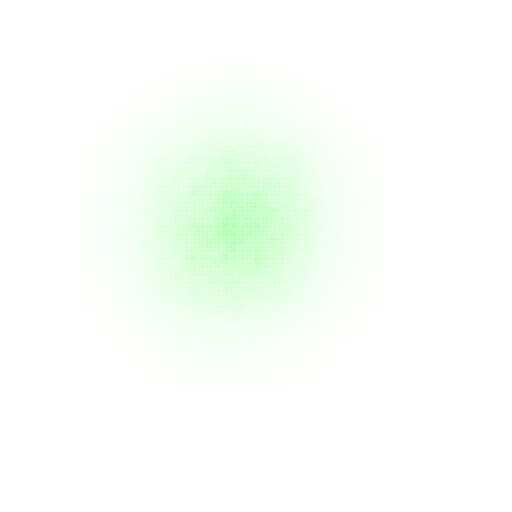

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models import resnet50
import torch
from torchvision import transforms
import numpy as np
import torchvision
from PIL import Image
import cv2
import os
#这里随机拿100张测试集图像，放到一个文件夹中，img_dir是文件夹路径
img_dir = "/Data_8TB/lht/data/ILSVRC/relitu_images"
images=os.listdir(img_dir)
model = resnet50(pretrained=True, progress=False)
model = model.eval()
#定义输入图像的长宽，这里需要保证每张图像都要相同
input_H, input_W = 512,512
#生成一个和输入图像大小相同的0矩阵，用于更新梯度
heatmap = np.zeros([input_H, input_W])
#打印一下模型，选择其中的一个层
print(model)

#这里选择骨干网络的最后一个模块
layer = model.layer4
print(layer)


def farward_hook(module, data_input, data_output):
    fmap_block.append(data_output)
    input_block.append(data_input)
    
#为了简单，这里直接一张一张图来算，遍历文件夹中所有图像  
for img in images:
    read_img = os.path.join(img_dir,img)
    image = Image.open(read_img)
    
    #图像预处理，将图像缩放到固定分辨率，并进行标准化
    image = image.resize((input_H, input_W))
    image = np.float32(image) / 255
    input_tensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])(image)
    
    #添加batch维度
    input_tensor = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        model = model.cuda()
        input_tensor = input_tensor.cuda()
        
    #输入张量需要计算梯度
    input_tensor.requires_grad = True
    fmap_block = list()
    input_block = list()
    
    #对指定层获取特征图
    layer.register_forward_hook(farward_hook)
    
    #进行一次正向传播
    output = model(input_tensor)
    
    #特征图的channel维度算均值且去掉batch维度，得到二维张量
    feature_map = fmap_block[0].mean(dim=1,keepdim=False).squeeze()
    
    #对二维张量中心点（标量）进行backward
    feature_map[(feature_map.shape[0]//2-1)][(feature_map.shape[1]//2-1)].backward(retain_graph=True)

    #对输入层的梯度求绝对值
    grad = torch.abs(input_tensor.grad)
    
    #梯度的channel维度算均值且去掉batch维度，得到二维张量，张量大小为输入图像大小
    grad = grad.mean(dim=1,keepdim=False).squeeze()
    
    #累加所有图像的梯度，由于后面要进行归一化，这里可以不算均值
    heatmap = heatmap + grad.cpu().numpy()
    
    
cam = heatmap

#对累加的梯度进行归一化
cam = cam / cam.max()

# #可视化，蓝色值小，红色值大
# cam = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
# print(cam.shape)
# cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
# Image.fromarray(cam)
# 自定义白色到绿色的颜色映射
def white_to_green_colormap(value):
    # value范围是0-255
    # 0: 白色 (255,255,255)
    # 255: 绿色 (0,255,0)
    r = 255 - value
    g = 255
    b = 255 - value
    return np.uint8([[[b, g, r]]])  # OpenCV使用BGR格式

# 应用自定义颜色映射
cam_normalized = np.uint8(cam * 255)
custom_cam = np.zeros((cam.shape[0], cam.shape[1], 3), dtype=np.uint8)
for i in range(cam.shape[0]):
    for j in range(cam.shape[1]):
        custom_cam[i, j] = white_to_green_colormap(cam_normalized[i, j])

# 转换为RGB格式
custom_cam = cv2.cvtColor(custom_cam, cv2.COLOR_BGR2RGB)
Image.fromarray(custom_cam)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import swin_transformer
import torch
from torchvision import transforms
import numpy as np
import torchvision
from PIL import Image
import cv2
import os
#这里随机拿100张测试集图像，放到一个文件夹中，img_dir是文件夹路径
img_dir = "/Data_8TB/lht/data/ILSVRC/relitu_images"
images=os.listdir(img_dir)
# model = deeplabv3_resnet50(pretrained=True, progress=False)
model = swin_transformer.swin_t(weights="IMAGENET1K_V1")
model = model.eval()
#定义输入图像的长宽，这里需要保证每张图像都要相同
input_H, input_W = 512, 512
#生成一个和输入图像大小相同的0矩阵，用于更新梯度
heatmap = np.zeros([input_H, input_W])
#打印一下模型，选择其中的一个层
print(model)

#这里选择骨干网络的最后一个模块
layer = model.features[7][0]
print(layer)


def farward_hook(module, data_input, data_output):
    fmap_block.append(data_output)
    input_block.append(data_input)
    
#为了简单，这里直接一张一张图来算，遍历文件夹中所有图像  
for img in images:
    read_img = os.path.join(img_dir,img)
    image = Image.open(read_img)
    
    #图像预处理，将图像缩放到固定分辨率，并进行标准化
    image = image.resize((input_H, input_W))
    image = np.float32(image) / 255
    input_tensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])(image)
    
    #添加batch维度
    input_tensor = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        model = model.cuda()
        input_tensor = input_tensor.cuda()
        
    #输入张量需要计算梯度
    input_tensor.requires_grad = True
    fmap_block = list()
    input_block = list()
    
    #对指定层获取特征图
    layer.register_forward_hook(farward_hook)
    
    #进行一次正向传播
    output = model(input_tensor)
    
    #特征图的channel维度算均值且去掉batch维度，得到二维张量
    feature_map = fmap_block[0].mean(dim=1,keepdim=False).squeeze()
    
    #对二维张量中心点（标量）进行backward
    feature_map[(feature_map.shape[0]//2-1)][(feature_map.shape[1]//2-1)].backward(retain_graph=True)

    #对输入层的梯度求绝对值
    grad = torch.abs(input_tensor.grad)
    
    #梯度的channel维度算均值且去掉batch维度，得到二维张量，张量大小为输入图像大小
    grad = grad.mean(dim=1,keepdim=False).squeeze()
    
    #累加所有图像的梯度，由于后面要进行归一化，这里可以不算均值
    heatmap = heatmap + grad.cpu().numpy()
    
    
cam = heatmap

#对累加的梯度进行归一化
cam = cam / cam.max()

# #可视化，蓝色值小，红色值大
# cam = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
# cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
# Image.fromarray(cam)
# 应用自定义颜色映射
cam_normalized = np.uint8(cam * 255)
custom_cam = np.zeros((cam.shape[0], cam.shape[1], 3), dtype=np.uint8)
for i in range(cam.shape[0]):
    for j in range(cam.shape[1]):
        custom_cam[i, j] = white_to_green_colormap(cam_normalized[i, j])

# 转换为RGB格式
custom_cam = cv2.cvtColor(custom_cam, cv2.COLOR_BGR2RGB)
Image.fromarray(custom_cam)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [1]:
from model.mobilemamba.starnet_mhsa_dwt import StarNet_MHSA

Can not import selective_scan_cuda_oflex. This affects speed.


/Data_8TB/lht/MobileMamba/model/lib_mamba/csms6s.py:13: UserWarning: Can not import selective_scan_cuda_oflex. This affects speed.
  warnings.warn("Can not import selective_scan_cuda_oflex. This affects speed.")


In [23]:
CFG_StarAttn_T4 = {
        'img_size': 224,
        'dims': [40,80,160,320],
        'depth': [1,2,4,5],
        'drop_path_rate': 0,
        'mlp_ratio': 2,
        "act_layer": "GELU",
        "learnable_wavelet": True,
        "down_sample": 32
    }


def StarNet_MHSA_T4_DTW(num_classes=1000, pretrained=False, distillation=False, fuse=False, pretrained_cfg=None, model_cfg=CFG_StarAttn_T4):
    model = StarNet_MHSA(num_classes=num_classes, distillation=distillation, **model_cfg)
    return model

In [24]:
model = StarNet_MHSA_T4_DTW()
model.eval()
model
import torch
import torch.onnx
import os

weight = torch.load('/Data_8TB/lht/MobileMamba/runs/starnet/StarAttn_new_t2_mhsa_dwt/CLSTrainer_StarNet_MHSA_T4_DTW_ImageFolderLMDB_20250907-221341/net_E.pth')

In [25]:
model.load_state_dict(weight)

<All keys matched successfully>

In [7]:
model

StarNet_MHSA(
  (patch_embed): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Conv2d_BN(
      (c): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Conv2d_BN(
      (c): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks1): Sequential(
    (0): Block(
      (DW): RepVGGDW(
        (conv): Conv2d_BN(
          (c): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
 

StarNet_MHSA(
  (patch_embed): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Conv2d_BN(
      (c): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Conv2d_BN(
      (c): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks1): Sequential(
    (0): Block(
      (DW): RepVGGDW(
        (conv): Conv2d_BN(
          (c): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
 

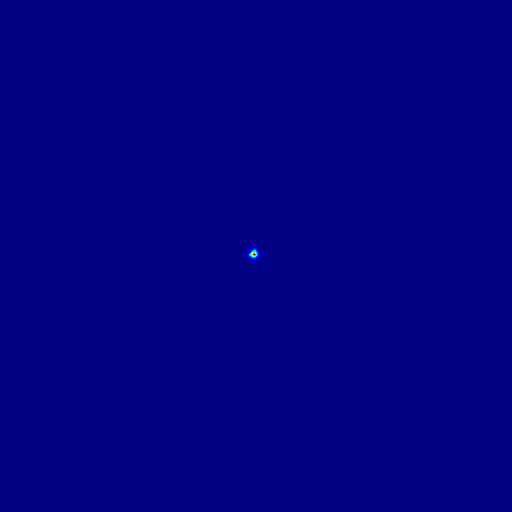

In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import swin_transformer
import torch
from torchvision import transforms
import numpy as np
import torchvision
from PIL import Image
import cv2
import os
#这里随机拿100张测试集图像，放到一个文件夹中，img_dir是文件夹路径
img_dir = "/Data_8TB/lht/data/ILSVRC/relitu_images"
images=os.listdir(img_dir)
# model = deeplabv3_resnet50(pretrained=True, progress=False)

#定义输入图像的长宽，这里需要保证每张图像都要相同
input_H, input_W = 512, 512
#生成一个和输入图像大小相同的0矩阵，用于更新梯度
heatmap = np.zeros([input_H, input_W])
#打印一下模型，选择其中的一个层
print(model)

#这里选择骨干网络的最后一个模块
layer = model.blocks1
print(layer)


def farward_hook(module, data_input, data_output):
    fmap_block.append(data_output)
    input_block.append(data_input)
    
#为了简单，这里直接一张一张图来算，遍历文件夹中所有图像  
for img in images:
    read_img = os.path.join(img_dir,img)
    image = Image.open(read_img)
    
    #图像预处理，将图像缩放到固定分辨率，并进行标准化
    image = image.resize((input_H, input_W))
    image = np.float32(image) / 255
    input_tensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])(image)
    
    #添加batch维度
    input_tensor = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        model = model.cuda()
        input_tensor = input_tensor.cuda()
        
    #输入张量需要计算梯度
    input_tensor.requires_grad = True
    fmap_block = list()
    input_block = list()
    
    #对指定层获取特征图
    layer.register_forward_hook(farward_hook)
    
    #进行一次正向传播
    output = model(input_tensor)
    
    #特征图的channel维度算均值且去掉batch维度，得到二维张量
    feature_map = fmap_block[0].mean(dim=1,keepdim=False).squeeze()
    
    #对二维张量中心点（标量）进行backward
    feature_map[(feature_map.shape[0]//2-1)][(feature_map.shape[1]//2-1)].backward(retain_graph=True)

    #对输入层的梯度求绝对值
    grad = torch.abs(input_tensor.grad)
    
    #梯度的channel维度算均值且去掉batch维度，得到二维张量，张量大小为输入图像大小
    grad = grad.mean(dim=1,keepdim=False).squeeze()
    
    #累加所有图像的梯度，由于后面要进行归一化，这里可以不算均值
    heatmap = heatmap + grad.cpu().numpy()
    
    
cam = heatmap

#对累加的梯度进行归一化
cam = cam / cam.max()

#可视化，蓝色值小，红色值大
cam = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
Image.fromarray(cam)